In [1]:
import os
import glob
import cv2
from PIL import Image
import numpy as np

# Define the root directory
root_dir = "data"

# Initialize lists for storing data
png_images = {}     
tiff_images = {}
cneg_files = {}
cpos_files = {}
pcd_files = {}

# Loop through folders 01 to 10
for i in range(1, 11):
    folder = os.path.join(root_dir, f"{i:02d}")  # Format 01, 02, ..., 10

    # Load TIFF and PNG images
    rgb_image_files = glob.glob(os.path.join(folder, "*.png"))
    rgb_image_files.sort()
    tiff_image_files = glob.glob(os.path.join(folder, "*.tiff"))
    tiff_image_files.sort()
    for rgb_img_path, tiff_img_path in zip(rgb_image_files, tiff_image_files):
        try:
            png_images[os.path.basename(rgb_img_path)] = Image.open(rgb_img_path)  # Using PIL
            tiff_images[os.path.basename(tiff_img_path)] = Image.open(tiff_img_path)  # Using PIL
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    # Load TXT files
    all_txt_files = glob.glob(os.path.join(folder, "*.txt"))
    all_txt_files.sort()
    for txt_path in all_txt_files:
        file_name = os.path.basename(txt_path)
        with open(txt_path, "r") as file:
            if "cneg" in file_name:
                cneg_files[file_name] = np.loadtxt(file)
            elif "cpos" in file_name:
                cpos_files[file_name] = np.loadtxt(file)
            else:
                pcd_files[file_name] = txt_path


/tmp/ipykernel_47927/1998358913.py:40: UserWarning: loadtxt: input contained no data: "<_io.TextIOWrapper name='data/01/pcd0154cneg.txt' mode='r' encoding='UTF-8'>"
  cneg_files[file_name] = np.loadtxt(file)


In [2]:
# Print sample outputs
print(f"Total rgb images loaded: {len(png_images)}")
print(f"Total tiff images loaded: {len(tiff_images)}")
print(f"Total cneg_files loaded: {len(cneg_files)}")
print(f"Total cpos_files loaded: {len(cpos_files)}")

Total rgb images loaded: 885
Total tiff images loaded: 885
Total cneg_files loaded: 885
Total cpos_files loaded: 885


In [3]:
cnegs = list(cneg_files.values())
cposs = list(cpos_files.values())
png_images_list = list(png_images.values())

In [4]:
png_images_names = list(png_images.keys())

In [5]:
import os
import cv2
import numpy as np


output_folder = 'output_images/with_bboxes'
os.makedirs(output_folder, exist_ok=True)

for i, (cneg, cpos) in enumerate(zip(cnegs, cposs)):
    image_overlay = np.array(png_images_list[i])
    
    # Process cneg (negative bounding boxes)
    for j in range(int(len(cneg)/4)):
        rect = cneg[j*4:(j+1)*4]
        pts = np.array(rect, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(image_overlay, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

    # Process cpos (positive bounding boxes)
    for j in range(int(len(cpos)/4)):
        rect = cpos[j*4:(j+1)*4]
        pts = np.array(rect, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(image_overlay, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    # Save the image to the output folder
    output_path = os.path.join(output_folder, png_images_names[i])
    cv2.imwrite(output_path, image_overlay)


/tmp/ipykernel_47927/1427850225.py:22: RuntimeWarning: invalid value encountered in cast
  pts = np.array(rect, np.int32)


KeyboardInterrupt: 

In [6]:
import argparse
import glob
import os
import numpy as np
from imageio import imsave
from depth_image import DepthImage

pcds = list(pcd_files.values())

for pcd in pcds:
    di = DepthImage.from_pcd(pcd, (480, 640))
    di.inpaint()

    of_name = pcd.replace('.txt', 'd.tiff')
    imsave(of_name, di.img.astype(np.float32))

KeyboardInterrupt: 

In [7]:
# Loop through folders 01 to 10
tiff_images = {}
for i in range(1, 11):
    folder = os.path.join(root_dir, f"{i:02d}")  # Format 01, 02, ..., 10
    tiff_image_files = glob.glob(os.path.join(folder, "*.tiff"))
    tiff_image_files.sort()
    for tiff_img_path in tiff_image_files:
        try:
            tiff_images[os.path.basename(tiff_img_path)] = Image.open(tiff_img_path)  # Using PIL
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

In [8]:
tiff_images_list = list(tiff_images.values())

In [9]:
tiff_images_names = list(tiff_images.keys())

In [10]:
output_folder = "output_images/rgbd/"
os.makedirs(output_folder, exist_ok=True)
for rgb_img, depth_img, name in zip(png_images_list, tiff_images_list, tiff_images_names):
    # Convert RGB image to a NumPy array
    rgb_array = np.array(rgb_img)
    
    # Convert depth image to NumPy array (float32)
    depth_array = np.array(depth_img, dtype=np.float32)
    
    depth_array = cv2.normalize(depth_array, None, 0, 255, cv2.NORM_MINMAX)
    depth_array = depth_array.astype(np.uint8)
    depth_array = np.expand_dims(depth_array, axis=-1)
    
    # Stack RGB image and depth image to form RGB-D image (4 channels)
    rgbd_image = np.concatenate((rgb_array, depth_array), axis=2)
    # Convert back to PIL Image (for saving)
    rgbd_image_pil = Image.fromarray(rgbd_image)
    rgbd_image_pil.save(output_folder+name.replace("d.tiff", "rgbd.png"))

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt

In [12]:
rgbd_folder = 'output_images/rgbd'
mask_folder = 'output_images/masks'
os.makedirs(mask_folder, exist_ok=True)

rgbd_images = glob.glob(os.path.join(rgbd_folder, "*.png"))
rgbd_images.sort()
for i, cpos in enumerate(cposs):
    image_overlay = np.array(Image.open(rgbd_images[i]))
    print(image_overlay.shape)
    zero_image = np.zeros_like(image_overlay)

    # Create a blank mask
    mask = np.zeros_like(image_overlay[:, :, 0])  # Single channel mask

    # Process cpos (positive bounding boxes)
    for j in range(int(len(cpos) / 4)):
        rect = cpos[j * 4:(j + 1) * 4]
        pts = np.array(rect, np.int32).reshape((-1, 1, 2))

        # Fill the polygon with white in the mask
        cv2.fillPoly(mask, [pts], 255)

    # Apply the mask to keep only the selected regions
    result = cv2.bitwise_and(image_overlay, image_overlay, mask=mask)
    # Save the image to the output folder
    output_path = os.path.join(mask_folder, png_images_names[i])
    cv2.imwrite(output_path, result)
    
print(f"images saved in {output_path}")
plt.imshow(result)

(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)
(480, 640, 4)


OSError: image file is truncated

In [13]:
masks_folder = 'output_images/masks'
yuv_folder = 'output_images/yuv'
depth_image_of_cpos = 'output_images/cpos_mask'
os.makedirs(yuv_folder, exist_ok=True)
os.makedirs(depth_image_of_cpos, exist_ok=True)

In [14]:
masks_image_files = glob.glob(os.path.join(masks_folder, "*.png"))
masks_image_files.sort()

In [15]:
for i, mask_image in enumerate(masks_image_files):
    image = np.array(Image.open(mask_image))
    yuv_image = cv2.cvtColor(image[:, :, :3], cv2.COLOR_RGB2YUV)
    depth_image_of_mask = image[:, :, 3]
    name = os.path.join(yuv_folder, png_images_names[i])
    cv2.imwrite(name, yuv_image)
    name = os.path.join(depth_image_of_cpos, png_images_names[i])
    cv2.imwrite(name, depth_image_of_mask)
plt.imshow(yuv_image)

IndexError: index 3 is out of bounds for axis 2 with size 3

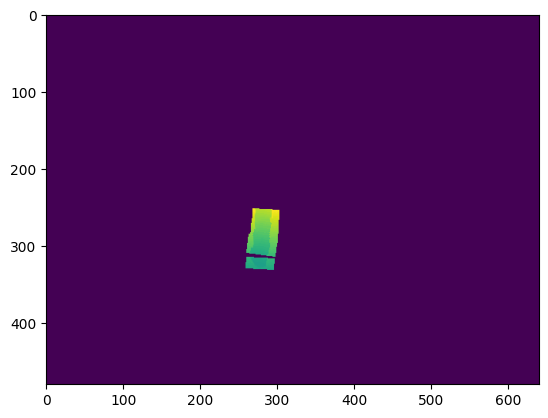

In [16]:
plt.imshow(depth_image_of_mask)

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)

In [ ]:
depth_image_of_cpos = 'output_images/cpos_mask'
pca_depth_path = "output_images/cpos_pca_depth"
os.makedirs(pca_depth_path, exist_ok=True)

In [ ]:
c_pos_depths = glob.glob(os.path.join(depth_image_of_cpos, "*.png"))
c_pos_depths.sort()

In [ ]:
for i, c_pos_depth in enumerate(c_pos_depths):
    c_pos_depth = np.array(Image.open(c_pos_depth))
    depth_flat = c_pos_depth.flatten().reshape(-1,1)
    depth_whitened = pca.fit_transform(depth_flat)
    depth_whitened_image = depth_whitened.reshape(c_pos_depth.shape)
    name = os.path.join(pca_depth_path, png_images_names[i])
    cv2.imwrite(name, depth_whitened_image)
plt.imshow(depth_whitened_image)

In [ ]:
norma = (depth_whitened_image - depth_whitened_image.min()) / (depth_whitened_image.max() - depth_whitened_image.min()) * 255

In [ ]:
plt.imshow(norma)

In [ ]:
!pip install open3d

In [17]:
with open(pcds[0], 'r') as f:
    # Skip header lines until 'DATA ascii'
    for line in f:
        if line.startswith('DATA ascii'):
            break

    # Read the numerical point cloud data
    pcd = np.loadtxt(f)

In [23]:
import open3d as o3d

cld = o3d.geometry.PointCloud()
cld.points = o3d.utility.Vector3dVector(pcd)

# Visualize the point cloud
o3d.visualization.draw_plotly([cld])

RuntimeError: 

In [22]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

ImportError: cannot import name 'JVisualizer' from 'open3d' (/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/open3d/__init__.py)